<a href="https://colab.research.google.com/github/theHoodguy4587/Sentiment-Analysis-AliExpress-/blob/main/aliexpress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install transformers datasets torch pandas scikit-learn
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
import gradio as gr

## Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Reviews.csv",sep="|")
df.head(5)

,buyerName,buyerCountry,Evaluation,buyerFeedback,buyerProductFeedBack,buyerTranslationFeedback,downVoteCount,upVoteCount,evalData,evaluationId,responsiveness,warrantyService,functionality,status
0,L***a,BR,100,Foi uma ótima compra. Item de acordo com o des...,NaN,Was a great buy. Item according to the describ...,0,0,09 Apr 2024,60080995549271264,NaN,NaN,NaN,1
1,Щ***ч,RU,100,Товар соответствует описанию. Визуально все в ...,NaN,Item as described. Visually everything is norm...,0,0,23 Jan 2024,50109430005211774,NaN,NaN,NaN,1
2,L***R,BR,100,"Possui um bom matéria, corrente bem fina pense...",NaN,"It has a good matter, very thin chain I though...",2,0,16 Dec 2023,60077029346436454,NaN,NaN,NaN,1
3,A***a,MX,100,no lo he probado pero parece lo suficientement...,NaN,I haven't tried it but it seems good enough to...,0,0,01 Jan 2024,60078089203734379,NaN,NaN,NaN,1
4,v***r,UA,100,Замовлення було швидко доставлено в Київ через...,NaN,Bulo Shvidko was delivered to Kiev through the...,0,0,06 Apr 2024,30070787000237584,NaN,NaN,NaN,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   buyerName                 2000 non-null   object 
 1   buyerCountry              2000 non-null   object 
 2   Evaluation                2000 non-null   int64  
 3   buyerFeedback             670 non-null    object 
 4   buyerProductFeedBack      0 non-null      float64
 5   buyerTranslationFeedback  670 non-null    object 
 6   downVoteCount             2000 non-null   int64  
 7   upVoteCount               2000 non-null   int64  
 8   evalData                  2000 non-null   object 
 9   evaluationId              2000 non-null   int64  
 10  responsiveness            0 non-null      float64
 11  warrantyService           0 non-null      float64
 12  functionality             0 non-null      float64
 13  status                    2000 non-null   int64  
dtypes: float

In [5]:
df.describe()

,Evaluation,buyerProductFeedBack,downVoteCount,upVoteCount,evaluationId,responsiveness,warrantyService,functionality,status
count,2000.000000,0.0,2000.000000,2000.00000,2.000000e+03,0.0,0.0,0.0,2000.0
mean,95.430000,NaN,0.084500,0.08050,4.303223e+16,NaN,NaN,NaN,1.0
std,13.557544,NaN,0.361144,0.43831,1.356860e+16,NaN,NaN,NaN,0.0
min,20.000000,NaN,0.000000,0.00000,2.004491e+16,NaN,NaN,NaN,1.0
25%,100.000000,NaN,0.000000,0.00000,3.006736e+16,NaN,NaN,NaN,1.0
50%,100.000000,NaN,0.000000,0.00000,3.007133e+16,NaN,NaN,NaN,1.0
75%,100.000000,NaN,0.000000,0.00000,6.007511e+16,NaN,NaN,NaN,1.0
max,100.000000,NaN,9.000000,10.00000,6.008124e+16,NaN,NaN,NaN,1.0


Handling Missing or Null Values


In [6]:
df.dropna(how='any',inplace=True,subset=['buyerFeedback'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 0 to 698
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   buyerName                 670 non-null    object 
 1   buyerCountry              670 non-null    object 
 2   Evaluation                670 non-null    int64  
 3   buyerFeedback             670 non-null    object 
 4   buyerProductFeedBack      0 non-null      float64
 5   buyerTranslationFeedback  670 non-null    object 
 6   downVoteCount             670 non-null    int64  
 7   upVoteCount               670 non-null    int64  
 8   evalData                  670 non-null    object 
 9   evaluationId              670 non-null    int64  
 10  responsiveness            0 non-null      float64
 11  warrantyService           0 non-null      float64
 12  functionality             0 non-null      float64
 13  status                    670 non-null    int64  
dtypes: float64(4), 

In [7]:
df = df.drop(columns= ['buyerProductFeedBack', 'responsiveness', 'warrantyService', 'functionality', 'status', 'buyerName', 'evaluationId']).reset_index()
df["Evaluation"] = df["Evaluation"]/20
df.head()

,index,buyerCountry,Evaluation,buyerFeedback,buyerTranslationFeedback,downVoteCount,upVoteCount,evalData
0,0,BR,5.0,Foi uma ótima compra. Item de acordo com o des...,Was a great buy. Item according to the describ...,0,0,09 Apr 2024
1,1,RU,5.0,Товар соответствует описанию. Визуально все в ...,Item as described. Visually everything is norm...,0,0,23 Jan 2024
2,2,BR,5.0,"Possui um bom matéria, corrente bem fina pense...","It has a good matter, very thin chain I though...",2,0,16 Dec 2023
3,3,MX,5.0,no lo he probado pero parece lo suficientement...,I haven't tried it but it seems good enough to...,0,0,01 Jan 2024
4,4,UA,5.0,Замовлення було швидко доставлено в Київ через...,Bulo Shvidko was delivered to Kiev through the...,0,0,06 Apr 2024


Explanatory Data Analysis

/tmp/ipython-input-275975881.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Evaluation',data=df,palette='viridis')


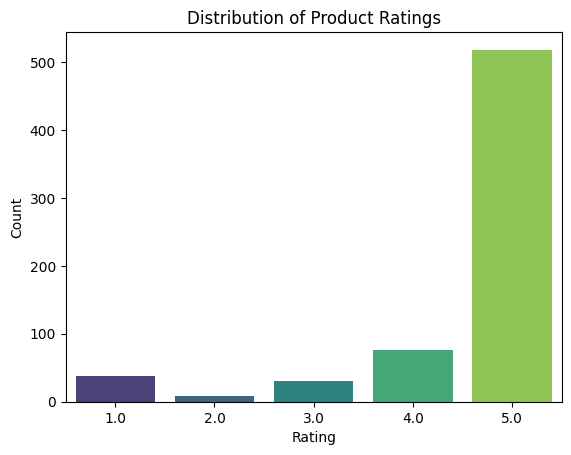

In [8]:
sns.countplot(x='Evaluation',data=df,palette='viridis')
plt.title("Distribution of Product Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Text(0, 0.5, 'Count')

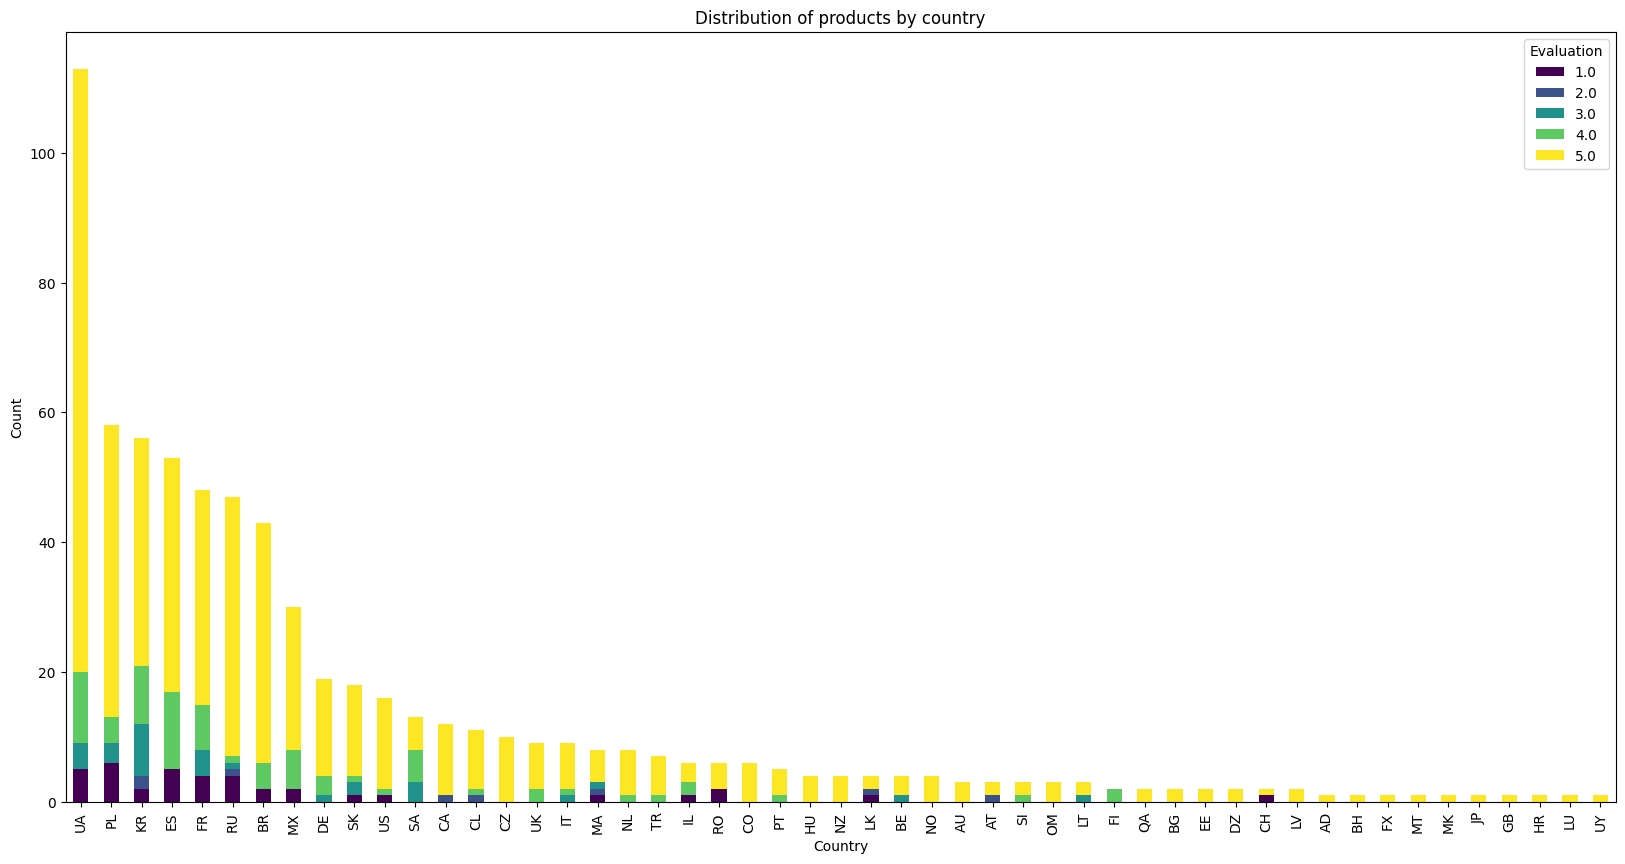

In [9]:
country_rating_counts=df.groupby(['buyerCountry','Evaluation']).size().unstack().fillna(0)
country_rating_counts['Total']=country_rating_counts.sum(axis=1)
country_rating_counts.sort_values(by='Total',ascending=False,inplace=True)
country_rating_counts.drop(columns='Total').plot(kind='bar',stacked=True,colormap='viridis',figsize=(20,10))
plt.title("Distribution of products by country")
plt.xlabel("Country")
plt.ylabel("Count")



Text Analysis

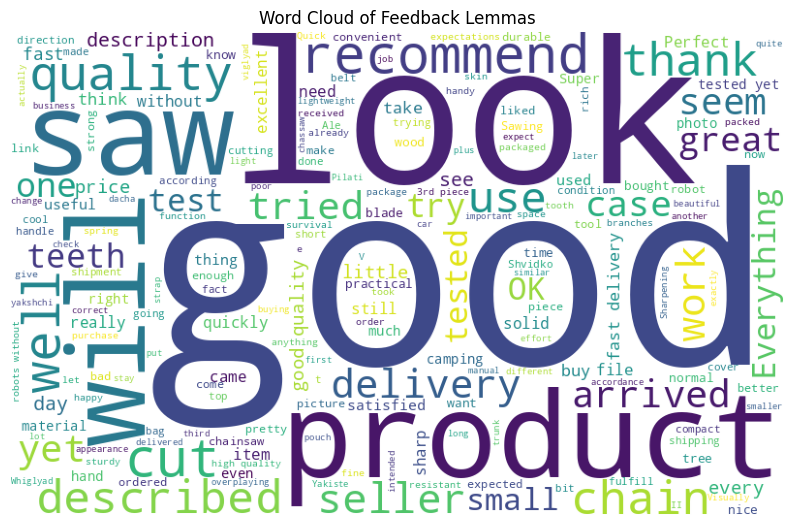

In [10]:
from wordcloud import WordCloud
all_lemmas=[word for sublist in df['buyerTranslationFeedback'] for word in sublist]

text=''.join(all_lemmas)

wordcloud=WordCloud(width=800,height=500,background_color='white').generate(text)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Feedback Lemmas')
plt.show()

In [11]:
def map_sentiment(rating):
  if rating<=2:
    return 0
  elif rating==3:
    return 1
  else:
    return 2
df['sentiment']=df['Evaluation'].apply(map_sentiment)

In [12]:
train_text,test_text,train_labels,test_labels=train_test_split(df['buyerFeedback'].tolist(),df['sentiment'].tolist(),test_size=0.2,random_state=42)

In [13]:
model_name="xlm-roberta-base"
tokenizer=AutoTokenizer.from_pretrained(model_name)
train_encodings=tokenizer(train_text,truncation=True,padding=True)
test_encodings=tokenizer(test_text,truncation=True,padding=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [14]:
import torch
class ReviewsDataset(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings=encodings
    self.labels=labels
  def __getitem__(self,idx):
    item={key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item['labels']=torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)
train_dataset=ReviewsDataset(train_encodings,train_labels)
test_dataset=ReviewsDataset(test_encodings,test_labels)

In [15]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.0 MB/s eta 0:00:00


In [16]:
from transformers.integrations import MLflowCallback
from transformers import AutoTokenizer,AutoModelForSequenceClassification,Trainer,TrainingArguments

model="cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer=AutoTokenizer.from_pretrained(model)
model=AutoModelForSequenceClassification.from_pretrained(model,num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.add_callback(MLflowCallback())
trainer.train()


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

2025/12/30 19:24:39 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/30 19:24:39 INFO mlflow.store.db.utils: Updating database tables
2025/12/30 19:24:39 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/30 19:24:39 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/30 19:24:39 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/30 19:24:39 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/30 19:24:39 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/30 19:24:39 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/30 19:24:39 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/30 19:24:39 INFO alembic.runtime.migration: Running 

Step,Training Loss


TrainOutput(global_step=201, training_loss=0.2859104023643987, metrics={'train_runtime': 142.1547, 'train_samples_per_second': 11.312, 'train_steps_per_second': 1.414, 'total_flos': 128082789520560.0, 'train_loss': 0.2859104023643987, 'epoch': 3.0})

In [17]:
trainer.evaluate

<bound method Trainer.evaluate of <transformers.trainer.Trainer object at 0x7b23a81cc6b0>>

In [18]:
model.save_pretrained("/content/drive/MyDrive/xlm_roberta_sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/xlm_roberta_sentiment_model")


('/content/drive/MyDrive/xlm_roberta_sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/xlm_roberta_sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/xlm_roberta_sentiment_model/sentencepiece.bpe.model',
 '/content/drive/MyDrive/xlm_roberta_sentiment_model/added_tokens.json',
 '/content/drive/MyDrive/xlm_roberta_sentiment_model/tokenizer.json')

In [19]:
from transformers import pipeline

# Update label_names to match the pipeline output
label_names = {
    "negative": "Negative",
    "neutral": "Neutral",
    "positive": "Positive"
}
sentiment_pipe=pipeline("sentiment-analysis",model="/content/drive/MyDrive/xlm_roberta_sentiment_model",tokenizer="/content/drive/MyDrive/xlm_roberta_sentiment_model")
result=sentiment_pipe("This is a very bad product")[0]
print(f"Predicted Sentiment: {label_names[result['label']]} ({result['score']:.3f})")

The tokenizer you are loading from '/content/drive/MyDrive/xlm_roberta_sentiment_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Device set to use cuda:0


Predicted Sentiment: Negative (0.988)


In [20]:
from transformers import pipeline
sentiment_pipe = pipeline("sentiment-analysis", model=model_name)
sentiment_pipe("මෙම නිෂ්පාදනය ඉතා ප්‍රයෝජනවත් වේ.")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.5515241622924805}]

In [21]:
import gradio as gr

def predict_sentiment(text):
  result=sentiment_pipe(text)[0]
  return f"Predicted Sentiment: {label_names[result['label']]} ({result['score']:.3f})"

demo=gr.Interface(fn=predict_sentiment,inputs="text",outputs="text",title="Sentiment Analysis")
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8fb455ea9a36595098.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
